<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Test8_mobilenet_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/data.zip" .
!unzip data.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: data/test/n_01593.jpg   
  inflating: data/test/n_01594.jpg   
  inflating: data/test/n_01605.jpg   
  inflating: data/test/n_01606.jpg   
  inflating: data/test/n_01607.jpg   
  inflating: data/test/n_01611.jpg   
  inflating: data/test/n_01626.jpg   
  inflating: data/test/n_01630.jpg   
  inflating: data/test/n_01634.jpg   
  inflating: data/test/n_01636.jpg   
  inflating: data/test/n_01645.jpg   
  inflating: data/test/n_01655.jpg   
  inflating: data/test/n_01657.jpg   
  inflating: data/test/n_01658.jpg   
  inflating: data/test/n_01659.jpg   
  inflating: data/test/n_01661.jpg   
  inflating: data/test/n_01666.jpg   
  inflating: data/test/n_01667.jpg   
  inflating: data/test/n_01668.jpg   
  inflating: data/test/n_01678.jpg   
  inflating: data/test/n_01683.jpg   
  inflating: data/test/n_01685.jpg   
  inflating: data/test/n_01686.jpg   
  inflating: data/test/n_01688.jpg   
  inflating: data/test/n_01694.jpg   
  inflating: data/

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( rescale=1./255, # 255で割ることで正規化
                              featurewise_center = False,
                              samplewise_center = False,
                              featurewise_std_normalization = False,
                              samplewise_std_normalization = False,
                              zca_whitening = False,
                              rotation_range = 10,
                              #width_shift_range = 0.3,
                              #height_shift_range = 0.3,
                              horizontal_flip = True,
                              vertical_flip = False,
                              validation_split = 0.2
                            )

In [3]:
train_dir = './data/train'
BATCH_SIZE = 32

train_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
  )

val_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
)

Found 3393 images belonging to 8 classes.
Found 845 images belonging to 8 classes.


In [4]:
from tensorflow.keras.applications import mobilenet

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3

base_model = mobilenet.MobileNet(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

base_model.trainable = False

for layer in base_model.layers[-60:]:
    layer.trainable = True


17225924/17225924 [==============================] - 0s 0us/step


In [5]:
from tensorflow.keras import datasets, layers, models, applications, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

CATEGORY_NUM = 8

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(CATEGORY_NUM, activation='softmax')
])

adam_low_rate = optimizers.Adam(learning_rate=0.001)

In [6]:
# モデルの概要
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [7]:
# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
from tensorflow import keras

# Early stoppingを適用してフィッティング
log = model.fit(
                  train_generator,
                  validation_data = val_generator,
                  steps_per_epoch = train_generator.samples // BATCH_SIZE,
                  validation_steps = val_generator.samples // BATCH_SIZE,
                  verbose=True,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                  epochs = 50,
                  workers = 1
)

Epoch 1/50
106/106 [==============================] - 74s 633ms/step - loss: 5.3863 - accuracy: 0.5022 - val_loss: 0.8033 - val_accuracy: 0.7188
Epoch 2/50
106/106 [==============================] - 67s 631ms/step - loss: 0.8885 - accuracy: 0.7090 - val_loss: 0.7258 - val_accuracy: 0.7380
Epoch 3/50
106/106 [==============================] - 75s 712ms/step - loss: 0.7080 - accuracy: 0.7569 - val_loss: 0.7358 - val_accuracy: 0.7272
Epoch 4/50
106/106 [==============================] - 74s 700ms/step - loss: 0.6419 - accuracy: 0.7783 - val_loss: 0.7094 - val_accuracy: 0.7584
Epoch 5/50
106/106 [==============================] - 76s 715ms/step - loss: 0.5347 - accuracy: 0.8143 - val_loss: 0.7002 - val_accuracy: 0.7500
Epoch 6/50
106/106 [==============================] - 74s 698ms/step - loss: 0.4683 - accuracy: 0.8438 - val_loss: 0.6292 - val_accuracy: 0.8089
Epoch 7/50
106/106 [==============================] - 76s 720ms/step - loss: 0.4503 - accuracy: 0.8503 - val_loss: 0.6930 - val_ac

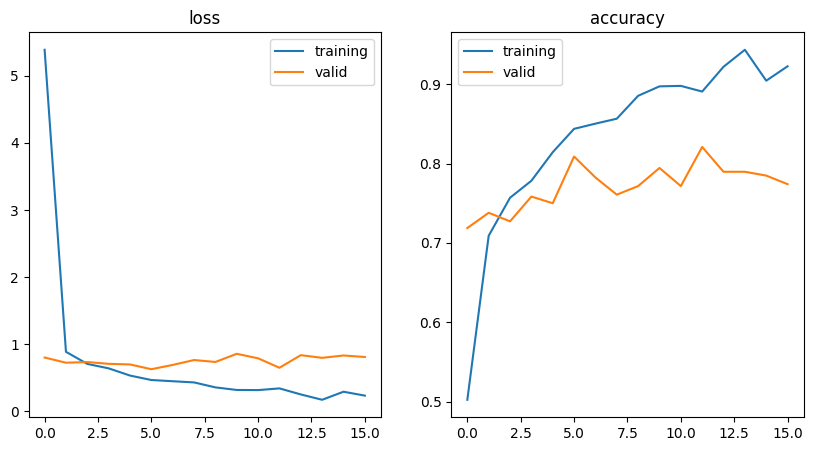

In [9]:
import matplotlib.pyplot as plt
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):

    metric = metrics[i]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
    plt.title(metric)

    plt_train = log.history[metric]
    plt_valid  = log.history['val_' + metric]

    plt.plot(plt_train, label='training')
    plt.plot(plt_valid, label='valid')
    plt.legend()

plt.savefig("metrics.jpg")

In [10]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_generator, val_generator.samples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=None))

27/27 [==============================] - 14s 521ms/step
Confusion Matrix
[[95 89 22  3 30  1  2]
 [98 68 24 10 57  1  0]
 [21 36  6  2  8  2  0]
 [21 28  4  1 19  0  1]
 [61 56 19  3 26  1  0]
 [ 1  5  0  1  3  0  0]
 [10  5  2  1  2  0  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.31      0.39      0.35       242
           1       0.24      0.26      0.25       258
           2       0.08      0.08      0.08        75
           3       0.05      0.01      0.02        74
           4       0.18      0.16      0.17       166
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        20

    accuracy                           0.23       845
   macro avg       0.12      0.13      0.12       845
weighted avg       0.21      0.23      0.22       845



Text(50.722222222222214, 0.5, 'true')

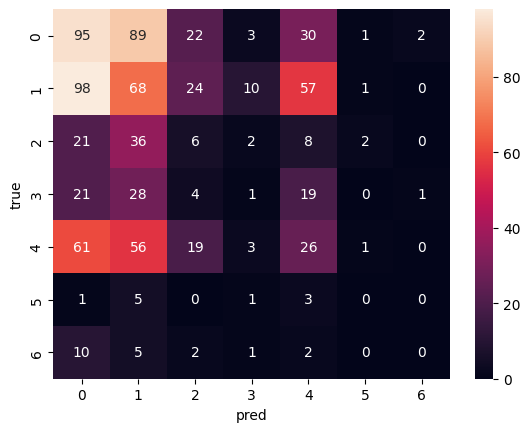

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True)
plt.xlabel("pred")
plt.ylabel('true')

In [12]:
# 評価する。
test_loss, test_acc = model.evaluate(val_generator)

print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")
model.save('/content/drive/MyDrive/Colab Notebooks/cnn_mobile.h5')

27/27 [==============================] - 13s 462ms/step - loss: 0.8067 - accuracy: 0.7858
test loss: 0.81, test accuracy: 78.58%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
#from tensorflow.keras.models import Model, load_model
#model = load_model('/content/drive/MyDrive/Colab Notebooks/cnn_dense121.h5')

In [14]:
test_dir = './data/test'

import os
import shutil
import glob

os.makedirs('./data/test/dummy', exist_ok=True)
for image_path in glob.glob(test_dir + '/*'):
    shutil.move(image_path, test_dir + '/dummy')

In [15]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(256,256), batch_size=64, class_mode=None, shuffle=False)

Found 1060 images belonging to 1 classes.


In [16]:
import numpy as np
prediction = model.predict(test_generator)
results = np.argmax(prediction,axis=1)
print(results)
np.savetxt('/content/drive/MyDrive/Colab Notebooks/save_ored.csv', results, delimiter=',')

17/17 [==============================] - 6s 234ms/step
[1 1 4 ... 2 0 1]
